### Model standard ML and statistical models to compare later to causal inference methods

A nuisance model in statistics refers to models that are not of primary interest but must be trained to accurately estimate the models that are of interest. They represent secondary models.

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import *
from pycaret.regression import *
from pycaret.classification import setup
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2
from utils.utils import *

Load sample data (trimmed)

In [3]:
samples = pd.read_csv("../data/df_ps_trimmed.csv")

Set the variables: Outcome (target), Treatment, Heterogeneity (zones), Confounders.

In [4]:
target = ['DI_agri_extreme_M7']

treatment = ['SMA_2']

zones = ['basin_lv2']

vars_list = ['E_gleam_ds','S_gleam_ds','H_gleam_ds',
            'sro_ds','sp_ds','tp_ds','d2m_ds',
            'agri_irri', 'agri_mix', 'agri_rain',
            'soil_clay', 'soil_oc', 'soil_roots','soil_sand', 'soil_tawc',
            'lst_night_ds','ndwi_ds',
            'pop','road','hand','lc2','lc3','lc5','lc8',
            'censo','soi_long','pdo_timeseries_sstens','noaa_globaltmp_comb']

Encode Xi (the heterogeneity features) - Create a one-hot ecoder (dummy variable)

In [5]:
zones_encoded = encode_categorical_raster(samples[zones[0]], prefix='zone')
samples_zones = samples.join(zones_encoded)
zone_vars = [v for v in samples_zones.columns if v.startswith(('zone'))]
samples_zones.head()

,lat,lon,time,CDI,DI_agri_extreme_M6,DI_agri_extreme_M7,E_gleam_ds,Eb_gleam_ds,Ei_gleam_ds,Ep_aero_gleam_ds,...,wp,id,SMA_2,zone_2020000010,zone_2020003440,zone_2020018240,zone_2020024230,zone_2020033490,zone_2020065840,zone_2020071190
0,64.0,11.5,2012-06-01,0.0,0,0,-0.144375,0.111538,-0.015348,0.102706,...,-1.39,64.0_11.5_2012,0,0,0,0,0,1,0,0
1,64.0,23.5,2012-06-01,0.0,0,0,-0.576725,0.023078,1.516387,-0.360590,...,-1.39,64.0_23.5_2012,0,0,0,0,1,0,0,0
2,64.0,24.5,2012-06-01,0.0,0,0,-0.722811,0.420203,0.842915,-0.176233,...,-1.39,64.0_24.5_2012,0,0,0,0,1,0,0,0
3,63.5,11.0,2012-06-01,0.0,0,0,-0.254223,0.291652,0.378889,-0.021234,...,-1.39,63.5_11.0_2012,0,0,0,0,0,1,0,0
4,63.5,22.5,2012-06-01,0.0,0,0,-0.718010,0.467551,1.119210,-0.595878,...,-1.39,63.5_22.5_2012,0,0,0,0,1,0,0,0


---
# Find the best nuisance models for O and T 

The target is to find the best model to predict the **Outcome** and the **Treatment**.

The best models will be used to train the residualizing models in the Causal Forest.

### Train several ML models for Treatment and Outcome classification

Suggestions to use:

- https://pycaret.readthedocs.io/en/stable/api/classification.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

#### Temporal sampling (2012-2019/2020-2022)

In [6]:
train_data, val_data, test_data = split_data_by_time(
    samples_zones, 
    time_col='time', 
    train_years=(2012, 2018), 
    val_years=(2019, 2020), 
    test_years=(2021, 2022)
)

Training set: 2012-2018
Validation set: 2019-2020
Testing set:  2021-2022
Lenght of training data: (5022, 103), Lenght of validation data: (2173, 103), lenght of test data: (2123, 103)


---
# Outcome nuisance model

In [7]:
# Binary variable -> classification problem -> probability of extreme drought (pedict row probability of class 1)

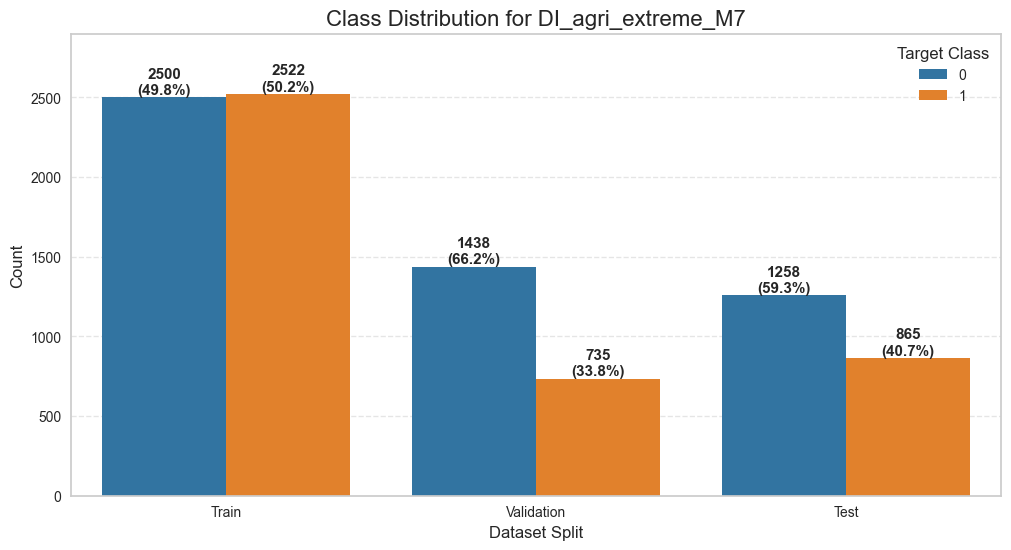

In [7]:
plot_class_distribution(
    train_data, 
    val_data, 
    test_data, 
    target_col=target,
)

In [17]:
# Setting up the PyCaret environment with the training data and generating a profile report
s = ClassificationExperiment()

s.setup(data=train_data[target + vars_list + zone_vars],
    target=target[0],
    test_data=val_data[target + vars_list + zone_vars],
    n_jobs=1,
    fold_strategy='stratifiedkfold',
    fold_shuffle=True, 
    fold=5)

,Description,Value
0,Session id,5056
1,Target,DI_agri_extreme_M7
2,Target type,Binary
3,Original data shape,"(7195, 38)"
4,Transformed data shape,"(7195, 38)"
5,Transformed train set shape,"(5022, 38)"
6,Transformed test set shape,"(2173, 38)"
7,Numeric features,37
8,Preprocess,True
9,Imputation type,simple


Model training and evaluation

In [9]:
models = s.compare_models(sort = 'F1', errors = 'raise', n_select = 10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9554,0.9917,0.9627,0.9493,0.9559,0.9108,0.9110,0.3500
lightgbm,Light Gradient Boosting Machine,0.9472,0.9893,0.9524,0.9434,0.9477,0.8945,0.8948,0.2860
rf,Random Forest Classifier,0.9452,0.9873,0.9508,0.9412,0.9458,0.8905,0.8909,1.0560
knn,K Neighbors Classifier,0.9168,0.9706,0.9318,0.9053,0.9183,0.8335,0.8339,0.0960
gbc,Gradient Boosting Classifier,0.9068,0.9695,0.9108,0.9045,0.9075,0.8136,0.8138,2.6380
dt,Decision Tree Classifier,0.8998,0.8998,0.9025,0.8986,0.9004,0.7997,0.7999,0.1060
ridge,Ridge Classifier,0.8355,0.8953,0.8501,0.8274,0.8385,0.6710,0.6714,0.0260
ada,Ada Boost Classifier,0.8345,0.9137,0.8541,0.8236,0.8382,0.6690,0.6700,0.6640
lda,Linear Discriminant Analysis,0.8343,0.8953,0.8454,0.8285,0.8368,0.6686,0.6689,0.0360
lr,Logistic Regression,0.8307,0.8967,0.8465,0.8221,0.8340,0.6614,0.6621,0.0620


In [10]:
for model in models:
    s.predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.6931,0.8439,0.8816,0.5277,0.6602,0.4109,0.4565


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6995,0.7522,0.8408,0.5355,0.6543,0.4108,0.4438


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7059,0.7957,0.8544,0.5414,0.6628,0.4245,0.4595


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.6742,0.7476,0.7673,0.5123,0.6144,0.3512,0.3728


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6949,0.7897,0.8082,0.5323,0.6418,0.3951,0.4214


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.6291,0.6306,0.6354,0.4647,0.5368,0.2397,0.2479


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.5665,0.6595,0.9469,0.4353,0.5964,0.2478,0.3423


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.6756,0.7479,0.7864,0.5133,0.6212,0.3587,0.3838


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.5242,0.8077,0.9741,0.4136,0.5807,0.2015,0.3154


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6291,0.8008,0.8993,0.4745,0.6212,0.3202,0.3849


Setting raw_score=True ensures you get the individual probability scores for each class.

In [11]:
for model in models:
    s.predict_model(model, data=test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.5916,0.4526,0.0601,0.4906,0.1071,0.0199,0.0388


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6208,0.7347,0.1526,0.6471,0.2470,0.1083,0.1590


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5968,0.6052,0.0173,0.7143,0.0339,0.0148,0.0624


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.3636,0.2831,0.1202,0.1499,0.1334,-0.3599,-0.3653


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5233,0.5584,0.0809,0.2439,0.1215,-0.1022,-0.1316


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5836,0.5188,0.1688,0.4695,0.2483,0.0418,0.0523


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.5516,0.6099,0.9249,0.4742,0.6270,0.1914,0.2673


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.6123,0.6771,0.4751,0.5269,0.4997,0.1847,0.1853


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.5469,0.5605,0.9746,0.4728,0.6367,0.1950,0.3046


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.4819,0.4599,0.5665,0.4033,0.4712,-0.0093,-0.0098


#### Select best model based on test set

In [18]:
best_model = s.create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8299,0.9165,0.8733,0.8047,0.8376,0.6595,0.6620
1,0.8229,0.9095,0.8356,0.8162,0.8258,0.6457,0.6459
2,0.8406,0.9188,0.8512,0.8346,0.8428,0.6812,0.6814
3,0.8237,0.9115,0.8433,0.8126,0.8277,0.6474,0.6478
4,0.8187,0.9107,0.8730,0.7885,0.8286,0.6373,0.6410
Mean,0.8272,0.9134,0.8553,0.8114,0.8325,0.6542,0.6556
Std,0.0076,0.0036,0.0154,0.0150,0.0066,0.0153,0.0146


Train model with train + validation samples

In [19]:
best_model = s.finalize_model(best_model)

Plot results on test data

In [20]:
# Re-initialize setup using your 2020-2022 data by putting our test set
test_set = s.setup(data = train_data[target + vars_list + zone_vars], 
            target = target[0], 
            test_data = test_data[target + vars_list + zone_vars],
            html = False)

                    Description               Value
0                    Session id                 966
1                        Target  DI_agri_extreme_M7
2                   Target type              Binary
3           Original data shape          (7145, 38)
4        Transformed data shape          (7145, 38)
5   Transformed train set shape          (5022, 38)
6    Transformed test set shape          (2123, 38)
7              Numeric features                  37
8                    Preprocess                True
9               Imputation type              simple
10           Numeric imputation                mean
11       Categorical imputation                mode
12               Fold Generator     StratifiedKFold
13                  Fold Number                  10
14                     CPU Jobs                  -1
15                      Use GPU               False
16               Log Experiment               False
17              Experiment Name    clf-default-name
18          

Generating error for 2020-2022 period...


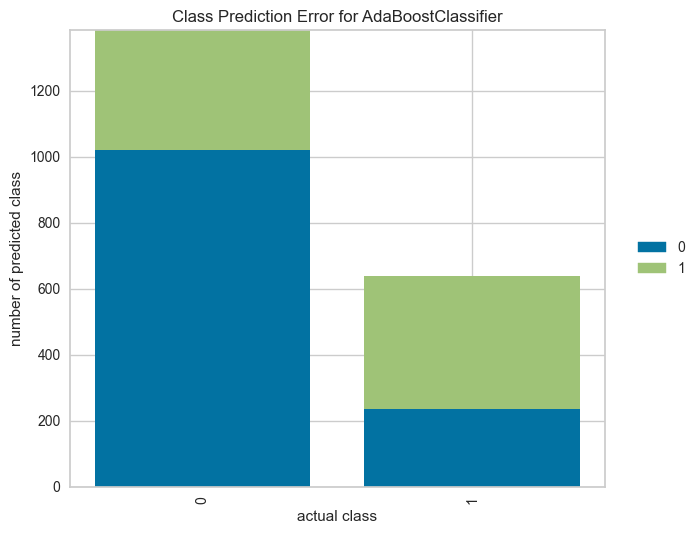

Generating auc for 2020-2022 period...


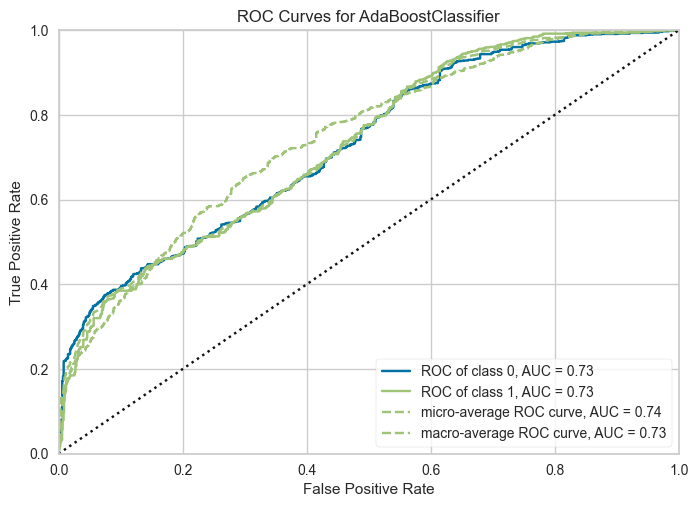

Generating pr for 2020-2022 period...


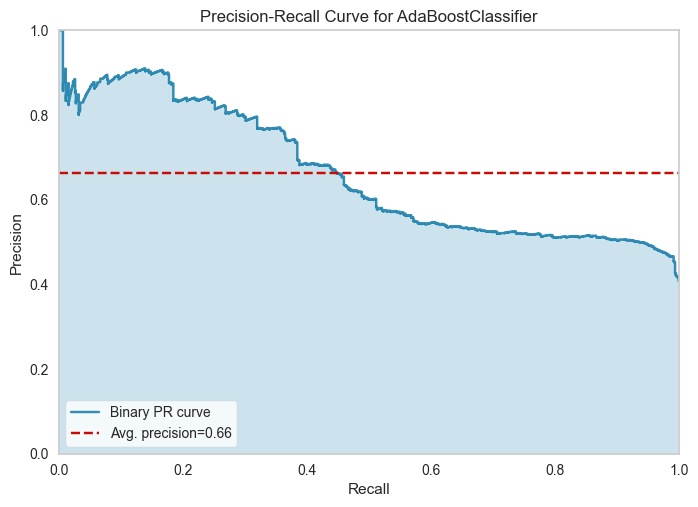

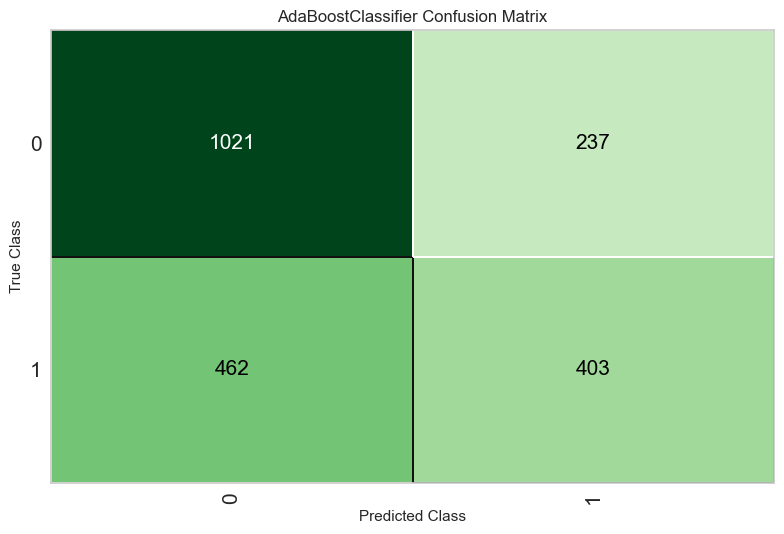

Generating confusion_matrix for 2020-2022 period...
Generating class_report for 2020-2022 period...


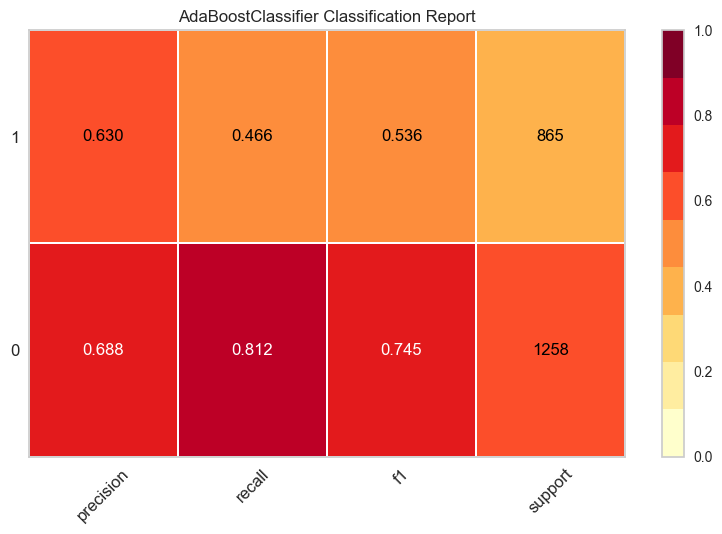

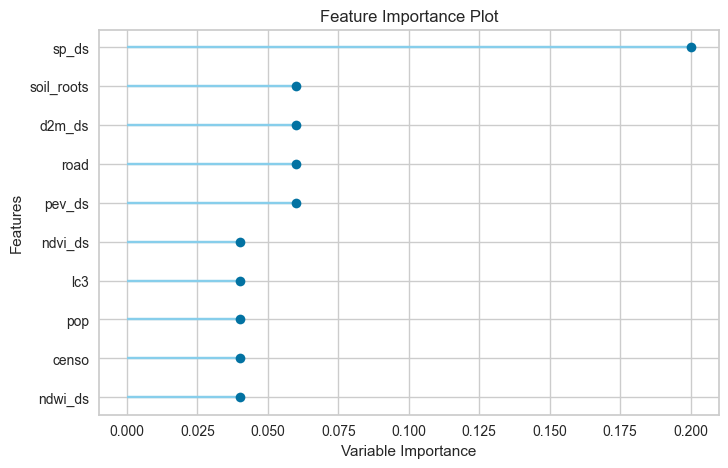

Generating feature for 2020-2022 period...


In [21]:
for plot in ['error', 'auc', 'pr','confusion_matrix','class_report','feature']:
    print(f"Generating {plot} for 2020-2022 period...")
    test_set.plot_model(best_model, plot=plot)

---
# Treatment nuisance model

In [22]:
# Binary variable -> classification problem -> probability of having an extreme soil moisture value (pedict row probability of class 1)

# Setting up the PyCaret environment with the training data and generating a profile report
s = ClassificationExperiment()

s.setup(data=train_data[treatment + vars_list + zone_vars],
    target=treatment[0],
    test_data=val_data[treatment + vars_list + zone_vars],
    n_jobs=1,
    fold_strategy='stratifiedkfold',
    fold_shuffle=True, 
    fold=5)

,Description,Value
0,Session id,4934
1,Target,SMA_2
2,Target type,Binary
3,Original data shape,"(7195, 38)"
4,Transformed data shape,"(7195, 38)"
5,Transformed train set shape,"(5022, 38)"
6,Transformed test set shape,"(2173, 38)"
7,Numeric features,37
8,Preprocess,True
9,Imputation type,simple


Model training and evaluation

In [23]:
models = s.compare_models(sort = 'F1', errors = 'raise', n_select = 10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8746,0.8745,0.5032,0.7658,0.6068,0.5360,0.5530,0.2440
et,Extra Trees Classifier,0.8751,0.8913,0.4649,0.8053,0.5894,0.5219,0.5494,0.3720
knn,K Neighbors Classifier,0.8554,0.8296,0.4731,0.6799,0.5577,0.4747,0.4859,0.0600
rf,Random Forest Classifier,0.8702,0.8712,0.4226,0.8151,0.5560,0.4889,0.5254,1.2000
gbc,Gradient Boosting Classifier,0.8624,0.8524,0.4050,0.7737,0.5315,0.4599,0.4932,2.6140
lda,Linear Discriminant Analysis,0.8548,0.8041,0.4163,0.7113,0.5251,0.4463,0.4687,0.0280
ada,Ada Boost Classifier,0.8489,0.8129,0.3988,0.6861,0.5038,0.4220,0.4440,0.6320
lr,Logistic Regression,0.8528,0.8067,0.3688,0.7364,0.4912,0.4162,0.4504,0.0660
ridge,Ridge Classifier,0.8548,0.8041,0.3450,0.7783,0.4780,0.4080,0.4537,0.0240
dt,Decision Tree Classifier,0.7965,0.6762,0.4803,0.4737,0.4763,0.3502,0.3506,0.1320


In [24]:
for model in models:
    s.predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7869,0.7335,0.1555,0.5481,0.2422,0.1610,0.2048


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7879,0.7619,0.0546,0.7027,0.1014,0.0720,0.1539


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.7722,0.7193,0.3550,0.4734,0.4058,0.2684,0.2726


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8021,0.7948,0.1660,0.7054,0.2687,0.2021,0.2741


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8242,0.7833,0.3655,0.6850,0.4767,0.3826,0.4099


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7547,0.8194,0.7437,0.4627,0.5705,0.4116,0.4343


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.8049,0.7487,0.2857,0.6182,0.3908,0.2929,0.3239


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8366,0.8198,0.5672,0.6444,0.6034,0.5010,0.5026


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8288,0.7506,0.6113,0.6088,0.6101,0.5004,0.5004


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.6921,0.5920,0.4139,0.3356,0.3706,0.1698,0.1714


Setting raw_score=True ensures you get the individual probability scores for each class.

In [25]:
for model in models:
    s.predict_model(model, data=test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7584,0.6742,0.0642,0.6667,0.1170,0.0766,0.1512


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7504,0.5289,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.7240,0.4966,0.0377,0.2083,0.0639,-0.0137,-0.0208


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7541,0.6265,0.0170,0.9000,0.0333,0.0243,0.1034


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7687,0.6751,0.1547,0.6560,0.2504,0.1714,0.2348


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.6656,0.6696,0.5906,0.3883,0.4686,0.2395,0.2507


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.7598,0.6105,0.0811,0.6515,0.1443,0.0942,0.1663


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7598,0.5977,0.1811,0.5581,0.2735,0.1722,0.2116


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7466,0.6309,0.4000,0.4907,0.4407,0.2791,0.2816


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.6387,0.5056,0.2396,0.2587,0.2488,0.0114,0.0114


#### Select best model based on test set

In [26]:
best_model = s.create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8607,0.7899,0.4330,0.7368,0.5455,0.4697,0.4928
1,0.8587,0.8202,0.4124,0.7407,0.5298,0.4545,0.4815
2,0.8496,0.8076,0.4093,0.6810,0.5113,0.4289,0.4483
3,0.8496,0.7909,0.4093,0.6810,0.5113,0.4289,0.4483
4,0.8556,0.8117,0.4175,0.7168,0.5277,0.4494,0.4723
Mean,0.8548,0.8041,0.4163,0.7113,0.5251,0.4463,0.4687
Std,0.0046,0.0119,0.0089,0.0260,0.0128,0.0157,0.0178


Train model with train + validation samples

In [27]:
best_model = s.finalize_model(best_model)

Plot results on test data

In [28]:
# Re-initialize setup using your 2020-2022 data by putting our test set
test_set = s.setup(data=train_data[treatment + vars_list + zone_vars],
            target=treatment[0],
            test_data=val_data[treatment + vars_list + zone_vars],
            html = False)

                    Description             Value
0                    Session id              1072
1                        Target             SMA_2
2                   Target type            Binary
3           Original data shape        (7195, 38)
4        Transformed data shape        (7195, 38)
5   Transformed train set shape        (5022, 38)
6    Transformed test set shape        (2173, 38)
7              Numeric features                37
8                    Preprocess              True
9               Imputation type            simple
10           Numeric imputation              mean
11       Categorical imputation              mode
12               Fold Generator   StratifiedKFold
13                  Fold Number                10
14                     CPU Jobs                -1
15                      Use GPU             False
16               Log Experiment             False
17              Experiment Name  clf-default-name
18                          USI              8002


Generating error for 2020-2022 period...


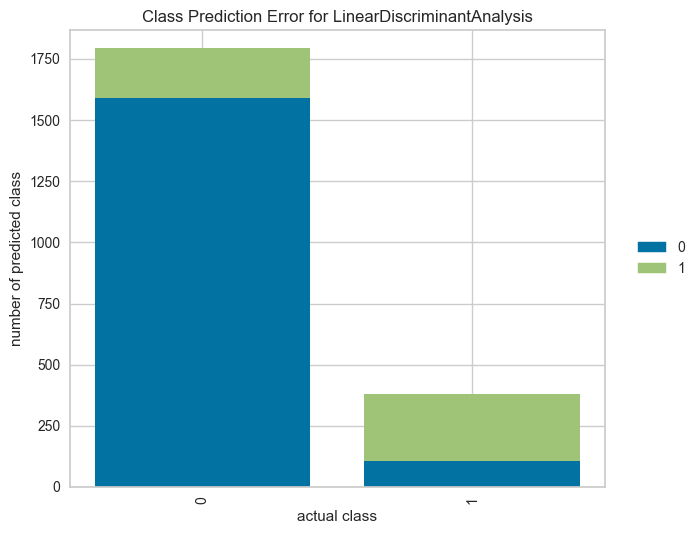

Generating auc for 2020-2022 period...


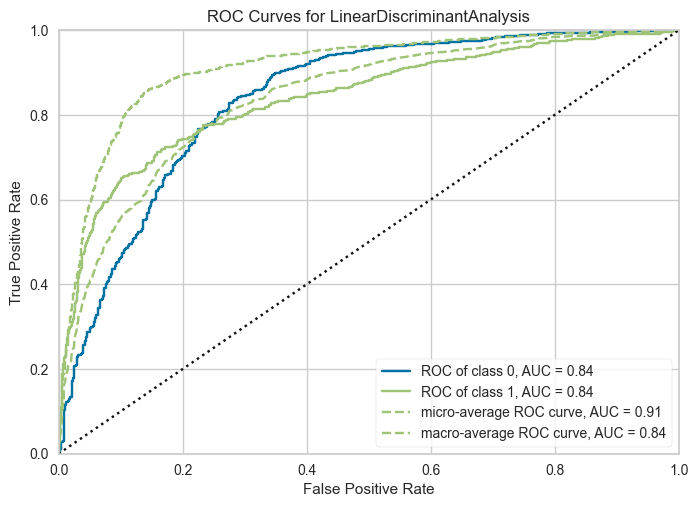

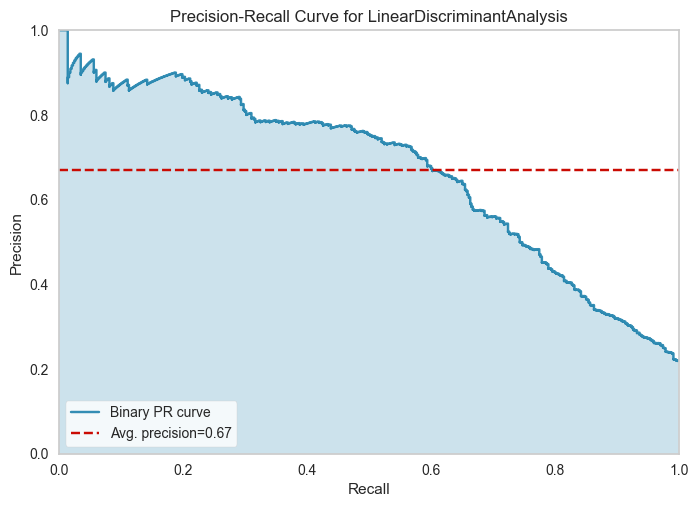

Generating pr for 2020-2022 period...


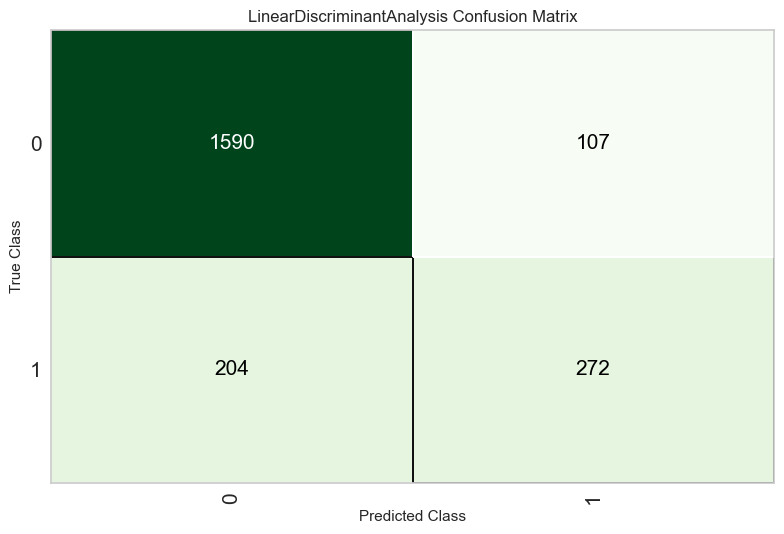

Generating confusion_matrix for 2020-2022 period...
Generating class_report for 2020-2022 period...


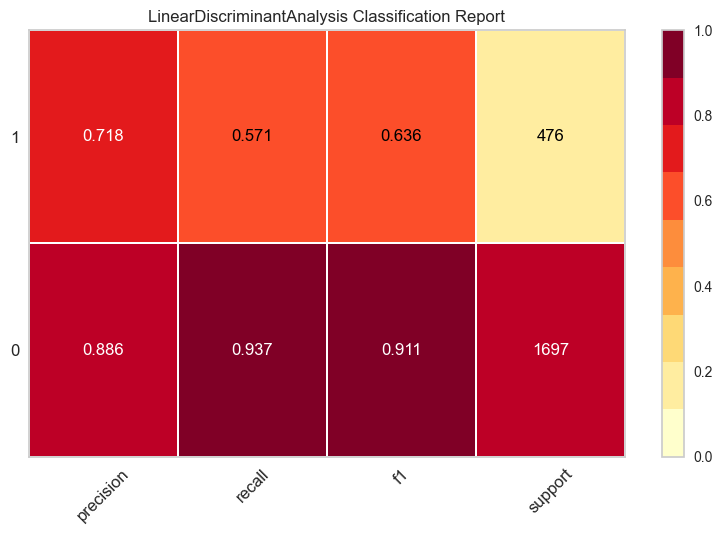

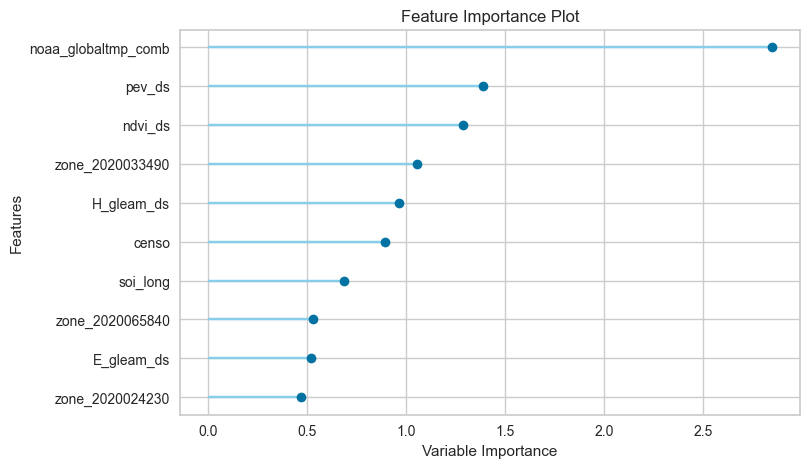

Generating feature for 2020-2022 period...


In [29]:
for plot in ['error', 'auc', 'pr','confusion_matrix','class_report','feature']:
    print(f"Generating {plot} for 2020-2022 period...")
    test_set.plot_model(best_model, plot=plot)